# Modelos de clasificación de texto

> Creando modelos de clasificación de texto usando FastAI y los datasets de HuggingFace.

- toc: true 
- badges: true
- comments: true
- categories: [practica]
- image: images/chart-preview.png


En este notebook se muestra cómo crear un modelo de clasificación de texto usando una variante de una red LSTM implementada en [FastAI](https://www.fast.ai/).

Para esta práctica es necesario el uso de GPU, así que recuerda activar esta opción en Colab. 

## Librerías

Comenzamos actualizando la librería FastAI y descargando la librería [datasets de HuggingFace](https://huggingface.co/docs/datasets/index). Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [ ]:
!pip install fastai -Uqq
!pip install datasets -Uqq

Cargamos a continuación las librerías que necesitaremos en esta práctica que son la parte de procesado de lenguaje natural de la librería fastAI, la librería pandas, y la funcionalidad para cargar datasets de HuggingFace.

In [1]:
import pandas as pd
from fastai.text.all import *
from datasets import load_dataset

## Dataset

Para este ejemplo vamos a usar el dataset [Gutenberg Poem Dataset](https://huggingface.co/datasets/poem_sentiment), un dataset para detectar sentimientos en poemas (negativos, positivos, sin impacto, mezcla de positivo y negativo).

Descarga el dataset usando el siguiente comando. 

In [2]:
poem_sentiment_dataset = load_dataset("poem_sentiment")

Using custom data configuration default
Reusing dataset poem_sentiment (/root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


  0%|          | 0/3 [00:00<?, ?it/s]

A continuación mostramos el dataset que hemos descargado.

In [3]:
poem_sentiment_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

Podemos ver que el dataset es una estructura DatasetDict que puede verse como un diccionario. El diccionario tiene tres claves que son train, validation y test que indican respectivamente los conjuntos de entrenamiento, validación y test (estas claves pueden variar dependiendo del dataset). Cada uno de estos subconjuntos es un Dataset que puede verse como una lista. Podemos ver por ejemplo la primera frase del conjunto de entrenamiento del siguiente modo. 

In [4]:
poem_sentiment_dataset["train"][0]

{'id': 0,
 'label': 1,
 'verse_text': 'with pale blue berries. in these peaceful shades--'}

Podemos ver también una descripción del dataset usando el atributo ``info``. 

In [5]:
print(poem_sentiment_dataset["train"].info)

DatasetInfo(description='Poem Sentiment is a sentiment dataset of poem verses from Project Gutenberg. This dataset can be used for tasks such as sentiment classification or style transfer for poems.\n', citation='@misc{sheng2020investigating,\n      title={Investigating Societal Biases in a Poetry Composition System},\n      author={Emily Sheng and David Uthus},\n      year={2020},\n      eprint={2011.02686},\n      archivePrefix={arXiv},\n      primaryClass={cs.CL}\n}\n', homepage='https://github.com/google-research-datasets/poem-sentiment', license='', features={'id': Value(dtype='int32', id=None), 'verse_text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=4, names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='poem_sentiment', config_name='default', version=1.0.0, splits={'train': SplitInfo(name='train', num_bytes=48667, num_examples=892, dataset_name='poem_sentiment'), 'vali

Por último, podemos ver las características de nuestro dataset utilizando el atributo ``features``. 

In [6]:
poem_sentiment_dataset["train"].features

{'id': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=4, names=['negative', 'positive', 'no_impact', 'mixed'], id=None),
 'verse_text': Value(dtype='string', id=None)}

Con el comando anterior podemos ver las cuatro clases de nuestro dataset, y los índices que les corresponden.

## Carga de datos

Cargamos a continuación el dataset en distintos dataframes de pandas (el formato que puede leer la librería de FastAI).

In [7]:
train_df = poem_sentiment_dataset["train"].to_pandas()
valid_df = poem_sentiment_dataset["validation"].to_pandas()
test_df = poem_sentiment_dataset["test"].to_pandas()

Podemos ver el contenido del dataset usando el siguiente comando.

In [8]:
train_df

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shades--,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, and the victories of mighty generals, i do not envy the generals,",3
4,4,of inward strife for truth and liberty.,3
...,...,...,...
887,887,to his ears there came a murmur of far seas beneath the wind,2
888,888,"the one good man in the world who knows me, --",1
889,889,faint voices lifted shrill with pain,0
890,890,"an', fust you knowed on, back come charles the second;",2


Del dataset nos interesan dos campos: `verse_text` (que contiene el poema) y `label` (que contiene el sentimiento).

In [9]:
train_df['verse_text']

0                                                                 with pale blue berries. in these peaceful shades--
1                                                                                it flows so long as falls the rain,
2                                                                                 and that is why, the lonesome day,
3      when i peruse the conquered fame of heroes, and the victories of mighty generals, i do not envy the generals,
4                                                                            of inward strife for truth and liberty.
                                                           ...                                                      
887                                                     to his ears there came a murmur of far seas beneath the wind
888                                                                   the one good man in the world who knows me, --
889                                                             

In [10]:
train_df['label']

0      1
1      2
2      0
3      3
4      3
      ..
887    2
888    1
889    0
890    2
891    0
Name: label, Length: 892, dtype: int64

Juntamos ahora nuestro conjunto de entrenamiento y de validación. Para poder diferenciarlos vamos a añadir una columna a cada uno de ellos para indicar al conjunto al que pertenecen. La columna ``set`` va a tener dos valores: True si pertenece al conjunto de validación y False si pertenece al conjunto de test.

In [11]:
train_df['set']=False
valid_df['set']=True

También eliminamos la columna ``id`` que no va a ser necesaria.

In [12]:
train_df = train_df.drop(columns=['id'],axis=1)
valid_df = valid_df.drop(columns=['id'],axis=1)

Ahora juntamos ambos datasets.

In [13]:
train_valid_df = pd.concat([train_df,valid_df])

Por último, hay que renombrar la columna ``verse_text`` por ``text`` (esto es una restricción de FastAI).

In [14]:
train_valid_df = train_valid_df.rename(columns={"verse_text": "text"})
train_valid_df

,text,label,set
0,with pale blue berries. in these peaceful shades--,1,False
1,"it flows so long as falls the rain,",2,False
2,"and that is why, the lonesome day,",0,False
3,"when i peruse the conquered fame of heroes, and the victories of mighty generals, i do not envy the generals,",3,False
4,of inward strife for truth and liberty.,3,False
...,...,...,...
100,"said my companion, 'i will show you soon",2,True
101,but god said,2,True
102,but if thou do thy best,2,True
103,"so generous to me. farewell, friend, since friend",1,True


## Entrenando un modelo

El proceso para entrenar un modelo es el mismo que hemos visto para los modelos de clasificación de imágenes y podemos usar toda la funcionalidad vista hasta ahora. Comenzamos definiendo un `DataBlock` que se creará a partir de nuestro dataframe `df`. Tendremos que definir también una función que nos indique cuándo un poema es del conjunto de entrenamiento o del de validación.   

In [15]:
sentiment_clas = DataBlock(
    blocks=(TextBlock.from_df('text'), CategoryBlock), # La entrada del modelo es texto, y la salida una clase 
    get_x=ColReader('text'),  # Indicamos donde estará el texto dentro del dataframe
    get_y=ColReader('label'), # Indicamos cómo extraer la clase del dataframe
    splitter=ColSplitter('set') # Partimos el dataset en entrenamiento y validación
)

Ahora definimos nuestro dataloader a partir del DataBlock que acabamos de crear (esto le puede costar unos segundos). 

In [16]:
dls = sentiment_clas.dataloaders(train_valid_df, bs=64)

Podemos mostrar un batch de nuestro dataloader. 

In [17]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos when i xxunk the xxunk xxunk of xxunk , and the xxunk of mighty xxunk , i do not envy the xxunk ,",3
1,"xxbos till , xxunk ' xxunk i know , there xxunk xxunk an xxunk xxunk i could lay my xxunk ' on ,",2


Pasamos ahora a crear nuestro `learner` usando el método `text_classifier_learner` al que pasamos como arquitectura de red la arquitectura [AWD_LSTM](https://arxiv.org/abs/1708.02182), además aplicamos dropout a nuestro modelo. 

In [18]:
callbacks = [ShowGraphCallback(),
             SaveModelCallback()]

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy,cbs=callbacks).to_fp16()

Ahora podemos utilizar toda la funcionalidad que ya vimos para clasificación de imágenes. Por ejemplo, podemos buscar un learning rate adecuado para entrenar nuestro modelo. 

SuggestedLRs(valley=0.002511886414140463)

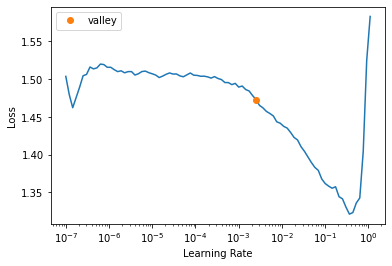

In [19]:
learn.lr_find()

Y a continuación aplicar fine tuning. 

epoch,train_loss,valid_loss,accuracy,time
0,1.432006,1.178530,0.638095,00:02


Better model found at epoch 0 with valid_loss value: 1.1785303354263306.


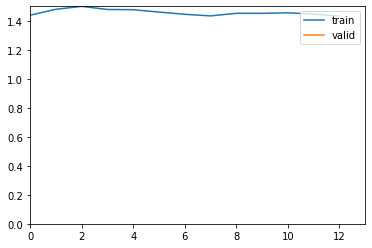

epoch,train_loss,valid_loss,accuracy,time
0,1.194728,1.150354,0.638095,00:02
1,1.108590,1.034699,0.657143,00:02
2,1.015784,1.019889,0.647619,00:02
3,0.909297,1.137827,0.685714,00:02
4,0.792113,1.079932,0.666667,00:02
5,0.691815,1.335006,0.628571,00:02
6,0.600908,1.133648,0.647619,00:02
7,0.505813,1.160434,0.666667,00:02
8,0.426953,1.188708,0.676190,00:02
9,0.370063,1.186051,0.685714,00:02


Better model found at epoch 0 with valid_loss value: 1.1503543853759766.


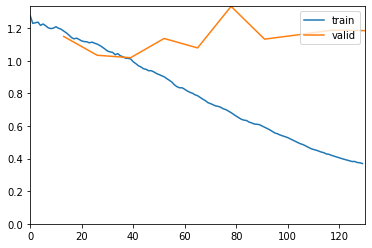

Better model found at epoch 1 with valid_loss value: 1.0346990823745728.
Better model found at epoch 2 with valid_loss value: 1.0198886394500732.


In [20]:
learn.fine_tune(10, 2e-2)

Ahora podemos usar nuestro modelo para predecir la clase de una nueva frase. 

In [21]:
learn.predict('with pale blue berries. in these peaceful shades--.')

('1', TensorText(1), TensorText([0.1539, 0.4554, 0.1342, 0.2565]))

Por último, podemos validar nuestro modelo en el conjunto de test, para lo cuál hay que combinar los dataframes y construir un nuevo dataloader. 

In [22]:
test_df['set']=True
test_df = test_df.drop(columns=['id'],axis=1)
train_test_df = pd.concat([train_df,test_df])
train_test_df = train_test_df.rename(columns={"verse_text": "text"})
dls_test = sentiment_clas.dataloaders(train_test_df, bs=64)

Modificamos ahora el dataloader de nuestro learner, y procedemos a validar.

In [23]:
learn.dls = dls_test
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5480769276618958.


(#2) [1.1024993658065796,0.5480769276618958]

Como podemos ver nuestro modelo tiene una accuracy del 66%. En las próximas prácticas veremos cómo mejorarlo. 